In [2]:
from colorsys import hls_to_rgb
from typing import Tuple, Union

import kwant
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from numpy.typing import ArrayLike
from tqdm.notebook import tqdm


def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    phase = (np.angle(z[idx]) + np.pi) / (2 * np.pi)
    phase = (phase + 0.5) % 1.0
    amplitude = 1.0 - 1.0 / (1.0 + abs(z[idx]) ** 0.3)
    color = [hls_to_rgb(p, a, 0.8) for p, a in zip(phase, amplitude)]
    c[idx] = color
    return c

In [3]:
# Pauli matrices
s0 = np.array([[1.0, 0.0], [0.0, 1.0]], dtype=complex)
sx = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=complex)
sy = np.array([[0.0, -1j], [1j, 0.0]], dtype=complex)
sz = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=complex)

# Kronecker products
t0s0 = np.kron(s0, s0)
t0sx = np.kron(s0, sx)
t0sy = np.kron(s0, sy)
t0sz = np.kron(s0, sz)

txs0 = np.kron(sx, s0)
txsx = np.kron(sx, sx)
txsy = np.kron(sx, sy)
txsz = np.kron(sx, sz)

tys0 = np.kron(sy, s0)
tysx = np.kron(sy, sx)
tysy = np.kron(sy, sy)
tysz = np.kron(sy, sz)

tzs0 = np.kron(sz, s0)
tzsx = np.kron(sz, sx)
tzsy = np.kron(sz, sy)
tzsz = np.kron(sz, sz)

In [4]:
def create_system(Nx, Ny, t, t_am, mu, hz=1e-6, periodic_bc=True):
    # Create a Kwant system
    lat = kwant.lattice.square(a=1, norbs=4)
    syst = kwant.Builder()

    def square(pos):
        (x, y) = pos
        return (abs(x) <= Nx) * (abs(y) <= Ny)

    def onsite(site1):
        (x, y) = site1.pos
        return (4 * t - mu) * tzs0 - hz * t0sz + txs0
        # + (1 - np.exp(-np.sqrt(x**2+y**2)/5)) * np.cos(np.arctan2(y, x)) * (+txs0)
        # + (1 - np.exp(-np.sqrt(x**2+y**2)/5)) * np.sin(np.arctan2(y, x)) * (-tys0))

    def hopx(site1, site2):
        return -t * tzs0 + t_am * t0sz

    def hopy(site1, site2):
        return -t * tzs0 - t_am * t0sz

    syst[lat.shape(square, (0, 0))] = onsite
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = hopx
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = hopy

    if periodic_bc:
        for i in range(-Ny, Ny + 1):
            syst[lat(Nx, i), lat(-Nx, i)] = hopx

        for i in range(-Nx, Nx + 1):
            syst[lat(i, Ny), lat(i, -Ny)] = hopy

    return lat, syst.finalized()

In [10]:
Nx = 81
Ny = 81
t = 10
t_am = 0
mu = 2 * t

lat, fsyst = create_system(Nx, Ny, t, t_am, mu, periodic_bc=True)

/tmp/ipykernel_188/3553902387.py:1: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().
  kwant.plot(fsyst);


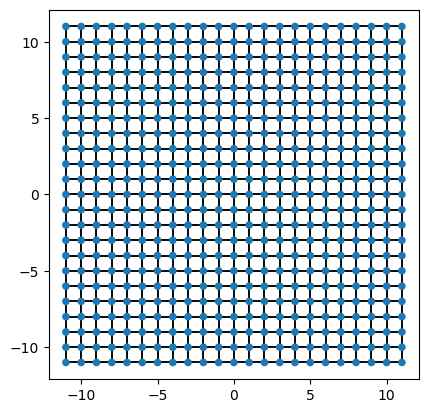

In [6]:
kwant.plot(fsyst);

In [83]:
# k = 10 # Number of eigenvalues calculated
# ws, vs = sla.eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=k, sigma=0)
# ws, vs = la.eigh(fsyst.hamiltonian_submatrix())

In [7]:
def operator(bra, ket):
    b = bra.reshape(-1, 4)
    k = ket.reshape(-1, 4)
    return np.einsum("ij, ik -> ijk", b, k.conj()).flatten()

In [8]:
kwant_op = kwant.operator.Density(fsyst, onsite=txs0, sum=False)
spectrum = kwant.kpm.SpectralDensity(
    fsyst, rng=0, energy_resolution=0.1, operator=kwant_op
)

In [9]:
densities.sum(-1).shape

NameError: name 'densities' is not defined

In [ ]:
# energies, densities = spectrum()
plt.plot(energies, densities.sum(-1));

In [ ]:
densities.shape

In [ ]:
# Sort eigensystem by energy
sort_idxs = np.argsort(ws)
ws = ws[sort_idxs]
vs = vs[:, sort_idxs]

idx = len(ws) // 2

In [ ]:
ws[idx]

In [ ]:
vvv[0]

In [ ]:
vvv = vs.reshape(-1, 4, len(ws))
cc = np.einsum("ijn, ikn -> ijkn", vvv[:, :2], vvv[:, 2:].conj())

In [ ]:
abs(vvv**2).sum(axis=0)

In [ ]:
plt.plot(np.trace(cc[0], axis1=0, axis2=1))

In [120]:
# Sort eigensystem by energy
sort_idxs = np.argsort(ws)
ws = ws[sort_idxs]
vs = vs[:, sort_idxs]

In [9]:
# Select the ev to plot
idx = 2

In [10]:
d_n_op = kwant.operator.Density(systf, onsite=t0s0)
d_q_op = kwant.operator.Density(systf, onsite=tzs0)
d_s_op = kwant.operator.Density(systf, onsite=tzsz)
d_d_op = kwant.operator.Density(systf, onsite=txs0)

d_n = d_n_op(vs[:, idx])
d_q = d_q_op(vs[:, idx])
d_s = d_s_op(vs[:, idx])
d_d = d_d_op(vs[:, idx])

In [11]:
d_d

array([ 5.76775789e-09,  5.05307927e-09, -8.11413771e-11, ...,
        8.11413771e-11, -5.05307927e-09, -5.76775789e-09])

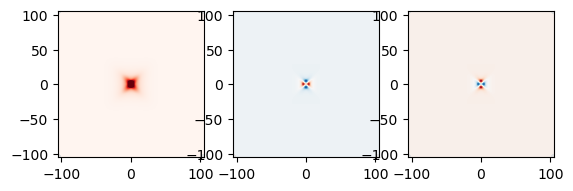

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

im1 = kwant.plotter.density(
    systf, d_n, ax=ax1, colorbar=True, cmap="Reds", vmin=0, vmax=abs(d_n).max()
)
im2 = kwant.plotter.density(systf, d_q, ax=ax2, colorbar=True, cmap="RdBu")
im3 = kwant.plotter.density(systf, d_s, ax=ax3, colorbar=True, cmap="RdBu");

In [21]:
j_n_op = kwant.operator.Current(systf, onsite=t0s0)
j_q_op = kwant.operator.Current(systf, onsite=tzs0)
j_s_op = kwant.operator.Current(systf, onsite=tzsz)

j_n = j_n_op(vs[:, idx])
j_q = j_q_op(vs[:, idx])
j_s = j_s_op(vs[:, idx])

(-35.0, 35.0)

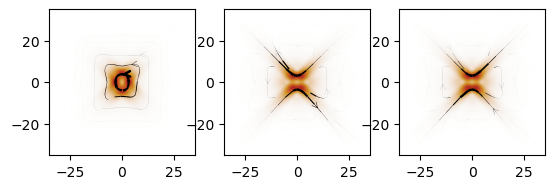

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

im1 = kwant.plotter.current(
    systf, j_n, ax=ax1, colorbar=True, min_linewidth=0.1, max_linewidth=2
)
im2 = kwant.plotter.current(
    systf, j_q, ax=ax2, colorbar=True, min_linewidth=0.1, max_linewidth=2
)
im3 = kwant.plotter.current(
    systf, j_s, ax=ax3, colorbar=True, min_linewidth=0.1, max_linewidth=2
)

ax1.set_xlim(-35, 35)
ax1.set_ylim(-35, 35)

ax2.set_xlim(-35, 35)
ax2.set_ylim(-35, 35)

ax3.set_xlim(-35, 35)
ax3.set_ylim(-35, 35)

In [13]:
L

NameError: name 'L' is not defined

In [21]:
aaa = abs(d_d_op(vs[:, idx], vs[:, idx].conj()));

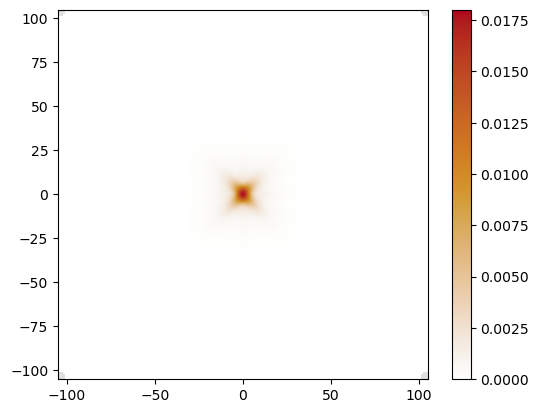

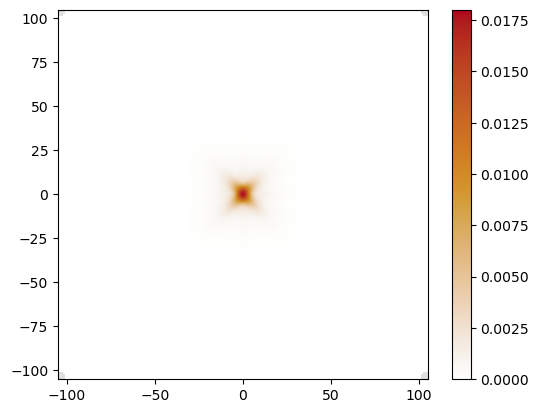

In [22]:
kwant.plotter.density(systf, aaa)